# Tracking with btrack

Duration : 120 images with confluent cells in the end and pretty crowded in the beginning -> 352 s.

In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from skimage import measure # to get contours from masks

# btrack module and configuration file
import btrack
from btrack.dataio import localizations_to_objects
from btrack.constants import BayesianUpdates
from btrack.render import plot_tracks

import re
import imagecodecs
import napari

C:\Users\Lab513\AppData\Roaming\Python\Python38\site-packages\napari\_qt\__init__.py:38: UserWarning: napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


## I. Load segmentation results

Attention : les prédictions sont encodées en float32 bits (sortie du réseau de neurones...).

In [20]:
os.chdir("D:/Hugo/Anaphase/Inter_Div_Correlation/H449_pos2_1-400/")  # root dir containg Predictions and Images Path

predictions_path = "BS300_H449_pos2_1-120_cleaned.tif"
corresponding_imgs = "D:\Hugo\Data\H449\pos2\BF"
RFP_path = "D:\Hugo\Data\H449\pos2\RFP"

predictions = imageio.volread(predictions_path).astype("int32")

# read images from dir
def alphanumeric_sort( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

X, target_shape, max_id = [], (512, 512), 120
for i, im in zip(range(max_id), alphanumeric_sort(os.listdir(corresponding_imgs))):
    X.append(cv2.resize(imageio.imread(os.path.join(corresponding_imgs, im)), target_shape))

Y, target_shape, max_id = [], (512, 512), 120
for i, im in zip(range(max_id), alphanumeric_sort(os.listdir(RFP_path))):
    Y.append(cv2.resize(imageio.imread(os.path.join(RFP_path, im)), target_shape))

# imgs = np.array(X)
imgs = np.concatenate([np.expand_dims(X, axis=-1), np.expand_dims(Y, axis=-1)], axis=-1)
# read images from stack
# imgs = imageio.volread(corresponding_imgs)

print(predictions.shape, imgs.shape)

def visualize_data_and_predictions(bf, pred, nc_ims=1, nc_masks=1):
    if nc_ims == 1:
        viewer = napari.view_image(bf[:, :, :])
    else:
        viewer = napari.view_image(bf[:, :, :, 0])  # bf
        for k in range(1, nc_ims):
            viewer.add_image(bf[:, :, :, k], blending="additive")
    if nc_masks == 1:
        viewer.add_labels(pred[:, :, :], blending="additive")#, colormap="blue")
    else:
        cmaps = ["bop blue", "red", "bop_orange", "blue", "bop purple"]
        for k in range(0, nc_masks):
            viewer.add_labels(pred[:, :, :, k], blending="additive")#, colormap=cmaps[k])

visualize_data_and_predictions(imgs, predictions, nc_ims=2, nc_masks=1)

(120, 512, 512) (120, 512, 512, 2)


In [16]:
imageio.volwrite("D:\Hugo\Anaphase\Inter_Div_Correlation\H449_pos2_1-400/BS300_H449_pos2_1-120_cleaned.tif", predictions)

## II. Get contours

### Thresholding to get the masks

In [21]:
retrieve_from_threshold = True  # when the masks have all pixels corresponding to objects with value 1 (or 255)

from skimage.filters import threshold_otsu
if retrieve_from_threshold:
    
    # Cast to 8-bit depth images prior to thresholding
    threshold_images = True
    if threshold_images:
        u8_predictions = []
    for p in predictions:
        u8_p = p - p.min()
        u8_p = u8_p / u8_p.max() * 255
        u8_predictions.append(np.uint8(u8_p))
    u8_predictions = np.array(u8_predictions)
    thresh = threshold_otsu(u8_predictions)
    masks = (u8_predictions > thresh).astype("uint8") * 255
    
    # plot images and masks
#     nb_imgs = 4
#     fig, ax = plt.subplots(1, nb_imgs, figsize=(16, 10))
#     for i, im in enumerate(imgs[:nb_imgs]):
#         ax[i].imshow(imgs[i], cmap="gray")
#         ax[i].imshow(masks[i], cmap="Spectral", alpha=0.2)
#         plt.axis("off")

#     plt.tight_layout()

<ipython-input-21-367edf326bee>:12: RuntimeWarning: invalid value encountered in true_divide
  u8_p = u8_p / u8_p.max() * 255


### Retrieve contours using skimage

<ipython-input-22-212c830a98e9>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_contours.append(np.array(c)) #threshold is defined when thresholding


(120,)


<ipython-input-22-212c830a98e9>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_contours = np.array(all_contours)


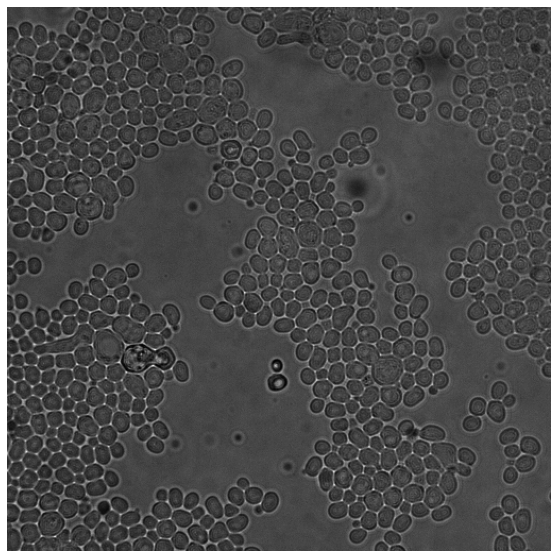

In [22]:
from skimage.filters import threshold_otsu
import time

import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

retrieve_from_threshold = True  # when the masks have all pixels corresponding to objects with value 1 (or 255)

if retrieve_from_threshold:
    all_contours = []
    for m in masks:
#         threshold = threshold_otsu(m)
        threshold = 127
        c = measure.find_contours(m, threshold)
        all_contours.append(np.array(c)) #threshold is defined when thresholding
    all_contours = np.array(all_contours)

    print(all_contours.shape)

    # Display the images and plot all contours found
    nb_imgs = 1
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    for i, (contour_im, im) in enumerate(zip(all_contours[19:20], imgs[19:20])):
        ax.imshow(cv2.resize(im[..., 0], (512, 512)), cmap="gray", origin="lower")
        for i, contour in enumerate(contour_im):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=5, c=names[i % len(names)])
        ax.axis("off")
else:  # one grey level per object in the masks
    all_contours = []
    for i, m in enumerate(predictions):
        if i % 10 == 0:
            print(f"Frame {i}")
#     t0 = time.time()
#     all_contours = [np.array([measure.find_contours(m == gray_level, level=gray_level-0.01)[0] for gray_level in np.unique(m)[1:]]) for m in predictions[:2]]
#     print(f"Duration : {round(time.time() - t0, 2)}")
        all_contours_at_this_frame = []
        for gray_level in np.unique(m)[1:]:  # don't take 0 as it is the background
            obj = np.array(m == gray_level, dtype=np.float32)
            contours = measure.find_contours(obj, level=0.99)  # list of contours
                                    
            all_contours_at_this_frame.append(contours[0])  # only one object per grey level, list of objects per frame

        all_contours_at_this_frame = np.array(all_contours_at_this_frame)  # one array per frame
        all_contours.append(all_contours_at_this_frame) 
        
    all_contours = np.array(all_contours)  # array of frames of objects
    
    print(all_contours.shape)
    
    init_idx, nb_frames = 0, 3
    fig, axes = plt.subplots(1, nb_frames, figsize=(8 * nb_frames, 8))
    for idx, (mask, contours, ax) in enumerate(zip(predictions[init_idx:init_idx+nb_frames], all_contours[init_idx:init_idx+nb_frames], axes)):
        ax.set_title(f"Frame {init_idx + idx}")
        ax.imshow(mask)
                
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0])

## III. Peform tracking using the surface and position of each cell at each time point

### Get the barycenter (position) of each cell at each time point and store them in a DataFrame

In [23]:
# retrieve all barycenters and shape a datastructure for btrack
positions_at_frames = []
for i, frame in enumerate(all_contours):
    for cell in frame:
        positions_at_frames.append({"t": i, "x": np.sum(cell[:, 1]) / cell.shape[0], "y": np.sum(cell[:, 0]) / cell.shape[0], "Contours": cell})
positions_per_frame = pd.DataFrame(positions_at_frames)

# check the shape
print(positions_per_frame.shape)

# Display the image and plot the barycenters to check if they're correct
# nb_imgs = 4
# fig, ax = plt.subplots(1, nb_imgs, figsize=(20, 20))

# for i, (contour_im, im) in enumerate(zip(all_contours[:nb_imgs], imgs[:nb_imgs])):
# #     ax[i].imshow(cv2.resize(im, (512, 512)), cmap="gray", origin="lower")
#     ax[i].imshow(im, cmap="gray", origin="lower")
#     for idx, cell in positions_per_frame[positions_per_frame["t"] == i].iterrows():
#         x, y = cell["x"], cell["y"]
#         ax[i].scatter(x, y)
#     ax[i].axis("off")

(3412, 4)


### Run position-based tracking with btrack

In [24]:
import time

# os.chdir("D:/Hugo/Python_Scripts/Notebooks")
MODE = BayesianUpdates.EXACT # APPROXIMATE or EXACT
objects = localizations_to_objects(positions_per_frame)

t0 = time.time()

# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file (example config file used here)
    tracker.configure_from_file("config_file.json")

  # set the update method and maximum search radius (both optional)
    tracker.update_method = MODE
    tracker.max_search_radius = 10

    # append the objects to be tracked
    tracker.append(objects)

    # set the volume (Z axis volume is set very large for 2D data)
    tracker.volume=((0,800),(0,800),(-1e5,1e5))
#     tracker.volume=((0,2500),(0,2500),(-1e5,1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimiser
#     tracker.optimize()  # veeeeery slow

    # get the tracks as a python list
    tracks = tracker.tracks
    box = tracker.volume
    
tf = time.time()
print(f"Tracking duration : {round(tf - t0, 2)} seconds.")

[INFO][2021/07/15 10:50:05 AM] Objects are of type: <class 'pandas.core.frame.DataFrame'>
[INFO][2021/07/15 10:50:05 AM] Loaded btrack: C:\ProgramData\Anaconda3\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2021/07/15 10:50:05 AM] btrack (v0.4.1) library imported
[INFO][2021/07/15 10:50:05 AM] Setting max XYZ search radius to: 100
[INFO][2021/07/15 10:50:05 AM] Starting BayesianTracker session
[INFO][2021/07/15 10:50:05 AM] Loading configuration file: config_file.json
[INFO][2021/07/15 10:50:05 AM] Loading motion model: b'cell_motion'
[INFO][2021/07/15 10:50:05 AM] Setting Bayesian update method to: BayesianUpdates.EXACT
[INFO][2021/07/15 10:50:05 AM] Setting max XYZ search radius to: 10
[INFO][2021/07/15 10:50:05 AM] Objects are of type: <class 'list'>
[INFO][2021/07/15 10:50:05 AM] Set volume to ((0, 800), (0, 800), (-100000.0, 100000.0))
[INFO][2021/07/15 10:50:05 AM] Starting tracking... 
[INFO][2021/07/15 10:50:05 AM] Tracking objects in frames 0 to 99 (of 120)...
[INFO][202

Tracking duration : 0.2 seconds.


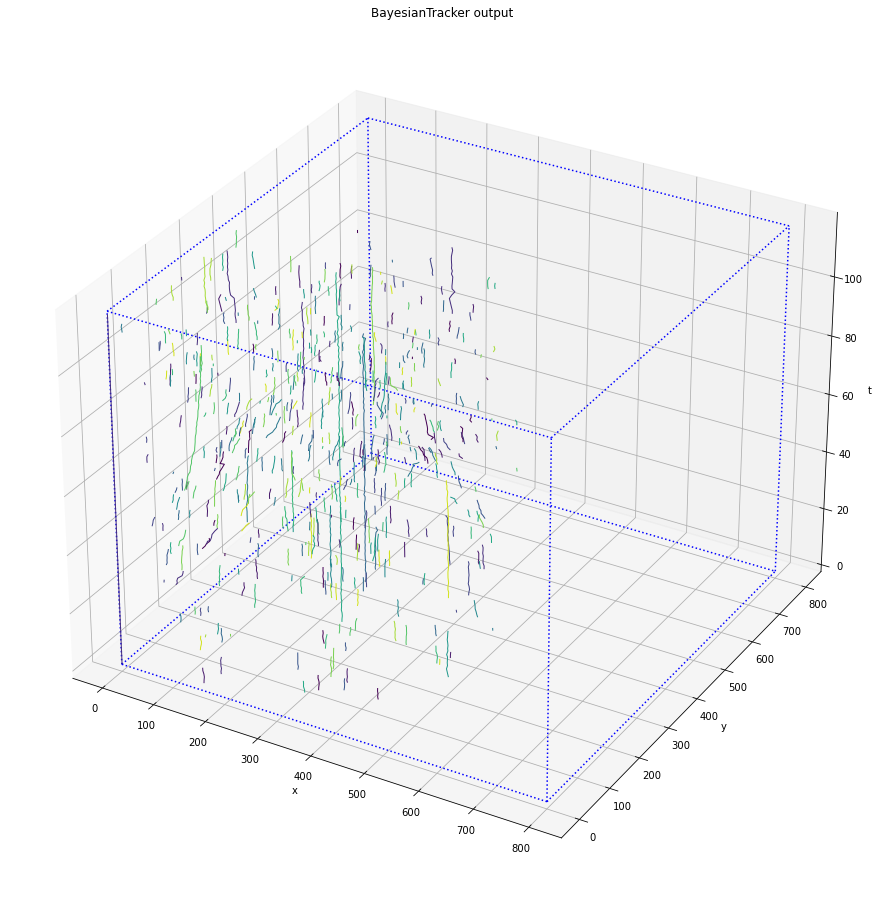

In [25]:
# plot the tracks in 3D
plot_tracks(tracks, order='xyt', box=box)

### Interactive view of the tracking results with napari

In [26]:
# Convert from the btrack format (data structure == OrderedDict) into a format that is accepted by Napari (i.e. numpy array)
tracks_to_napari = []
for track in tracks:
    for i, frame in enumerate(track.t):
        tracks_to_napari.append({"ID": track.ID, "Frame": frame, "X": track.y[i], "Y": track.x[i]}) #, "Contours": track["Contours"][i]})
tracks_to_napari = pd.DataFrame(tracks_to_napari)

print(tracks_to_napari.shape)
print(tracks_to_napari[:10])

(3275, 4)
   ID  Frame          X           Y
0   1      0  19.404781  147.952381
1   1      1  20.109542  147.838095
2   1      2  21.176209  147.876190
3   1      3  21.057539  147.203540
4   1      4  21.071447  145.380952
5   1      5  21.619284  144.816514
6   2      0   0.250980    0.250980
7   2      1   0.250980    0.250980
8   2      2   0.250980    0.250980
9   2      3   0.250980    0.250980


In [33]:
resized = []
for im in imgs:
    resized.append(cv2.resize(im, (512, 512)))
resized = np.array(resized)

print(resized.shape)

# with napari.gui_qt():
viewer = napari.view_image(resized[..., 0])
viewer.add_image(resized[..., 1])
# viewer.add_labels(predictions, opacity=0.5, blending="additive")#, colormap="blue")
# viewer.add_tracks(tracks_to_napari)

(120, 512, 512, 2)


<Image layer 'Image [1]' at 0x2008ca9fa00>

### Save the Tracking results (DataFrame) and the contours (npy) to files

In [28]:
# Convert from the btrack format (data structure == OrderedDict) into a format that is accepted by Napari (i.e. numpy array)
to_save = []
for track in tracks:
    for i, frame in enumerate(track.t):
        to_save.append({"ID": track.ID, "Frame": frame, "X": track.y[i], "Y": track.x[i], "Contours": track["Contours"][i]})
to_save = pd.DataFrame(to_save)

contours = to_save["Contours"].values
print(contours.shape)

(3275,)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [31]:
for idx in to_save["ID"].unique():
    traj = to_save[to_save["ID"] == idx]
    
    if traj.shape[0] == 1:
        print(idx)
        print(traj)

17
     ID  Frame           X           Y  \
392  17      1  487.202169  480.680851   

                                              Contours  
392  [[493.5019607843137, 484.0], [493.501960784313...  
18
     ID  Frame           X           Y  \
393  18      1  502.689494  468.410526   

                                              Contours  
393  [[510.5019607843137, 463.0], [510.501960784313...  
55
     ID  Frame           X           Y  \
638  55     18  429.396927  499.010309   

                                              Contours  
638  [[442.5019607843137, 499.0], [442.501960784313...  
58
     ID  Frame           X           Y  \
649  58     21  383.855159  160.448598   

                                              Contours  
649  [[391.5019607843137, 154.0], [391.501960784313...  
68
     ID  Frame           X           Y  \
724  68     24  359.705626  486.869159   

                                              Contours  
724  [[371.5019607843137, 493.0], [371.50196078

In [32]:
# Save the tracking results in a csv (without contours)
save_path = "H449_pos2_1-400_anaphase.csv"
to_save.drop("Contours", axis=1).to_csv(save_path, sep=",", index=False)

# Save the contours in numpy text file
save_path = "H449_pos2_1-400_anaphase.npy"
np.save(save_path, contours)